# Callbacks

> State's callbacks and variables

In [ ]:
#| default_exp callbacks

In [ ]:
#|export
from dataclasses import dataclass

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The weights matrix is not fully connected")

In [ ]:
#|export
from pysal.lib import weights
from pysal.explore import esda
import itertools
import fastcore.all as fc
from fastcore.basics import patch
import numpy as np
from scipy.spatial import KDTree
import geopandas as gpd
from typing import List
from collections.abc import Callable
import rasterio
from rasterio.mask import mask
import pandas as pd
from typing import Type

In [ ]:
#| hide
from trufl.utils import gridder
from trufl.sampler import Sampler
from trufl.collector import DataCollector
import pandas as pd

red, black = '#BF360C', '#263238'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#|export
@dataclass
class Variable:
    "State variable"
    name: str
    value: float

In [ ]:
#|export
class Callback(): pass

## State

In [ ]:
#|export
class State:
    def __init__(self, 
                 measurements:gpd.GeoDataFrame, # Measurements data with `loc_id`, `geometry` and `value` columns. 
                 smp_areas:gpd.GeoDataFrame, # Grid of areas/polygons of interest with `loc_id` and `geometry`.
                 cbs:List[Callable], # List of Callback functions returning `Variable`s.
                ): 
        "Collect various variables/metrics per grid cell/administrative unit."
        fc.store_attr()
        self.unsampled_locs = self.smp_areas.index.difference(self.measurements.index)

In [ ]:
#| export
@patch
def get(self:State, 
        loc_id:str, # Unique id of the Point feature
        as_numpy=False # Whether or not to return a list of `Variable` or a tuple of numpy arrays.
       ):
    "Get the state variables as defined by `cbs` for a given location (`loc_id`)."
    variables = self.run_cbs(loc_id)
    if as_numpy:
        return (np.array([v.name for v in variables]), 
                np.array([v.value for v in variables]))
    else:
        return variables

In [ ]:
#| export
@patch
def __call__(self:State, loc_id=None, **kwargs):
    "Get the state variables as defined by `cbs` for all `loc_id`s as a dataframe."
    loc_ids = self.smp_areas.index
    results = [{v.name: v.value for v in self.run_cbs(loc_id)} | {'loc_id': loc_id} for loc_id in loc_ids]
    return pd.DataFrame(results).set_index('loc_id')

In [ ]:
#| export
@patch
def expand_to_k_nearest(self:State, 
                        subset_measurements:gpd.GeoDataFrame, # Measurements for which Variables are computed.
                        k:int=5, # Number of nearest neighbours (possibly belonging to adjacent cells/admin. units to consider).
                       ):
    "Expand measurements of concern possibly to nearest neighbors of surrounding grid cells."
    tree = KDTree(self.measurements.geometry.apply(lambda p: (p.x, p.y)).tolist());
    _, indices = tree.query(subset_measurements.geometry.apply(lambda p: (p.x, p.y)).tolist(), k=k)
    return self.measurements.iloc[indices.flatten()].reset_index(drop=True)

In [ ]:
#| export
@patch
def _flatten(self:State, variables):
    "Flatten list of variables potentially containing both scalar and tuples."
    return list(itertools.chain(*(v if isinstance(v, tuple) else (v,) 
                                  for v in variables)))

In [ ]:
#| export
@patch
def run_cbs(self:State, loc_id):
    "Run Callbacks sequentially and flatten the results if required."
    variables = []
    for cb in self.cbs:
        variables.append(cb(loc_id, self))
    return self._flatten(variables)

## Callbacks

In [ ]:
#|export
class MaxCB(Callback):
    "Compute Maximum value of measurements at given location."
    def __init__(self, name='Max'): fc.store_attr()
    def __call__(self, 
                 loc_id:int, # Unique id of an individual area of interest. 
                 o:Type[State] # A State's object
                ): 
        if loc_id in o.unsampled_locs: return Variable(self.name, np.nan)
        return Variable(self.name, 
                        np.max(o.measurements.loc[[loc_id]].value.values))

In [ ]:
#|export
class MinCB(Callback):
    "Compute Minimum value of measurements at given location."
    def __init__(self, name='Min'): fc.store_attr()
    def __call__(self, 
                 loc_id:int, # Unique id of an individual area of interest. 
                 o:Type[State] # A State's object
                ): 
        if loc_id in o.unsampled_locs: return Variable(self.name, np.nan)
        return Variable(self.name, 
                    np.min(o.measurements.loc[[loc_id]].value.values))

In [ ]:
#|export
class StdCB(Callback):
    "Compute Standard deviation of measurements at given location."
    def __init__(self, name='Standard Deviation'): fc.store_attr()
    def __call__(self, 
                 loc_id:int, # Unique id of an individual area of interest. 
                 o:Type[State] # A State's object
                ): 
        if loc_id in o.unsampled_locs: return Variable(self.name, np.nan)
        return Variable(self.name, 
                    np.std(o.measurements.loc[[loc_id]].value.values))

In [ ]:
#|export
class CountCB(Callback):
    "Compute the number of measurements at given location."
    def __init__(self, name='Count'): fc.store_attr()
    def __call__(self, 
                 loc_id:int, # Unique id of an individual area of interest. 
                 o:Type[State] # A State's object
                ): 
        if loc_id in o.unsampled_locs: return Variable(self.name, np.nan)
        return Variable(self.name, 
                        len(o.measurements.loc[[loc_id]].value.values))

In [ ]:
#|export
class MoranICB(Callback):
    "Compute Moran.I of measurements at given location. Return NaN if p_sim above threshold."
    def __init__(self, k=5, p_threshold=0.05, name='Moran.I', min_n=5): fc.store_attr()

    def _weights(self, measurements):
        w = weights.KNN.from_dataframe(measurements, k=self.k)
        w.transform = "R" # Row-standardization
        return w
        
    def __call__(self, 
                 loc_id:int, # Unique id of an individual area of interest. 
                 o:Type[State] # A State's object
                ): 
        if loc_id in o.unsampled_locs: return Variable(self.name, np.nan)
        subset = o.measurements.loc[[loc_id]]
        if len(subset) <= self.min_n: return Variable(self.name, np.nan)
        expanded_measurements = o.expand_to_k_nearest(subset, k=self.k)
        moran = esda.moran.Moran(expanded_measurements['value'], self._weights(expanded_measurements))
        return Variable(self.name, moran.I if moran.p_sim < self.p_threshold else np.nan)

In [ ]:
#|export
class PriorCB(Callback):
    "Emulate a prior by taking the mean of measurement over a single grid cell."
    def __init__(self, 
                 fname_raster:str, # Name of raster file
                 name:str='Prior' # Name of the State variable
                ): 
        fc.store_attr()

    def __call__(self, 
                 loc_id:int, # Unique id of an individual area of interest. 
                 o:Type[State] # A State's object
                ): 
        polygon = o.smp_areas.loc[o.smp_areas.reset_index().loc_id == loc_id].geometry
        with rasterio.open(self.fname_raster) as src:
            out_image, out_transform = mask(src, polygon, crop=True)
            mean_value = np.mean(out_image)
        return Variable(self.name, mean_value)

For example:

1. We generate a grid from a given raster file:

In [ ]:
#|eval: false
fname_raster = 'files/ground-truth-01-4326-simulated.tif'
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)

2. Then, we can emulate a data collection campaign:

In [ ]:
#|eval: false
# Define random samples where to collect data
sampler = Sampler(gdf_grid)
np.random.seed(41)
n = np.random.randint(0, high=10, size=len(gdf_grid), dtype=int)
sample_locs = sampler.sample(n, method='uniform')

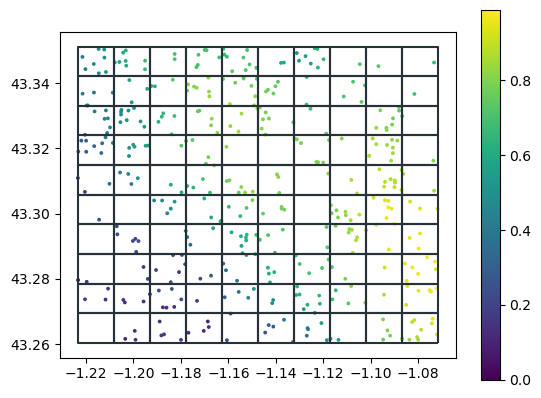

In [ ]:
#|eval: false
# Emulate data collection
dc_emulator = DataCollector(fname_raster)
samples_t0 = dc_emulator.collect(sample_locs)

ax = samples_t0.plot(column='value', s=3, legend=True)
gdf_grid.boundary.plot(color=black, ax=ax);

3. Finally, we specify the variables of current `State` and return it:

In [ ]:
#|eval: false
state = State(samples_t0, gdf_grid, cbs=[
    MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)
])

# You have to call the instance
state_t0 = state(); state_t0

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,NaN,NaN,NaN,NaN,NaN,0.102492
1,0.180137,0.131248,0.020143,3.0,NaN,0.125727
2,0.155227,0.000000,0.077614,2.0,NaN,0.161802
3,NaN,NaN,NaN,NaN,NaN,0.184432
4,0.248508,0.248508,0.000000,1.0,NaN,0.201405
...,...,...,...,...,...,...
95,0.851829,0.848570,0.001630,2.0,NaN,0.803670
96,0.796904,0.796904,0.000000,1.0,NaN,0.763408
97,NaN,NaN,NaN,NaN,NaN,0.727797


**Why the `expand_to_k_nearest` method?**

The `Moran.I` index is a statistical method used to determine if there is a significant spatial autocorrelation in a dataset. It helps to characterize the level of spatial correlation within each area of interest, such as a cell in your example.

However, when analyzing spatial data, it's important to consider not just the correlation within each area, but also the correlation between areas that are close to each other. In other words, we need to take into account points that are "nearby" but "belong" to different areas.

The `expand_to_k_nearest` method is a technique that can help with this. It takes a list of points and expands it to include the nearest k-neighbors. This can be useful for identifying spatial patterns that might not be apparent when only considering the points within each area in isolation.

By combining the `Moran.I` index with the `expand_to_k_nearest` method, you can gain a more comprehensive understanding of the spatial patterns in your data, taking into account both the correlation within each area and the correlation between nearby areas. 

The cell below allows to visualize it in action:

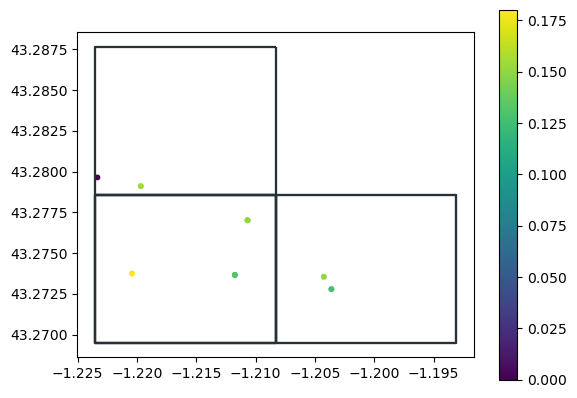

In [ ]:
#|eval: false

# Select measurements belonging to loc_id=1
subset = state.measurements.loc[[1]]; subset.head()
# Expand to k-nearest neighbors
expanded_pts = state.expand_to_k_nearest(subset, k=5)

# Look how the k-nearest neighbors from adjacent areas are now incuded
ax = expanded_pts.plot(column='value', s=10, legend=True)
gpd.sjoin(gdf_grid, expanded_pts, how="inner", predicate='contains').boundary.plot(color=black, ax=ax);

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()